## Preprocessing

training corpus: 2001 year, 8717 docs

In [1]:
import zipfile
from zipfile import ZipFile

In [2]:
# открываем зипфайл и читаем его
with zipfile.ZipFile("C:\\tmdasha\\MUNru.zip", 'r') as z:
  z.extractall('MUN')

print('Done')

Done


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dvb07\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Сохраняем наши стоп-слова
with open('C:\\tmdasha\\stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

# Загружаем дополнительно стоп-слова из NLTK
stop_words.extend(stopwords.words('russian'))
# Избавляемся от дубликатов
stw = list(stop_words)

In [5]:
#print(stw)

In [6]:
import os

In [7]:
corpus_files = os.listdir('MUN/MUN')

In [8]:
import pymorphy2 as pm
morph = pm.MorphAnalyzer()

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dvb07\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
docs = []

# Предобрабатываем данные (предобработка одинаковая для всех моделей)
for ind, txt in enumerate(corpus_files):
    with open('MUN/MUN//' + txt, 'r', encoding='utf-8') as f:
        text = nltk.word_tokenize(f.read().lower())
        text = [token for token in text if len(token) > 2]
        text = [morph.parse(token)[0].normal_form for token in text if token not in stop_words]
        # Each document should contain lemmatized words separated by spaces
        docs.append(' '.join(text))

In [10]:
#print(docs)


---


---



## ScikitLearn

In [11]:
N_FIRST = 10  # сколько первых слов на тему выводить
MIN_DF = 5  # минимальное число вхождений слова в документ, 
            # чтобы мы его учитывали (включали в вектор документа)
MAX_DF = 0.95  # в каком проценте документов должно присутствовать слово,
               #  чтобы оно не рассматривалось

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
docs = list(docs)

In [14]:
vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF,
                                   stop_words=stw)
docs_vectorized = vectorizer.fit_transform(docs)

C:\Users\dvb07\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ак', 'акад', 'буль', 'вкз', 'гр', 'дисс'] not in stop_words.
  warnings.warn(


In [15]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=20, learning_method='batch', batch_size=512, random_state=2)
lda_model.fit_transform(docs_vectorized)

array([[1.97976221e-01, 2.71443659e-02, 1.77952192e-01, ...,
        1.88668192e-02, 2.69707077e-01, 3.93116053e-02],
       [5.65128852e-04, 3.62806223e-01, 5.65138728e-04, ...,
        2.23826526e-01, 7.52266672e-02, 9.98364039e-02],
       [3.43805676e-01, 9.45450133e-05, 4.68844896e-01, ...,
        8.08705223e-02, 9.45444011e-05, 5.15700728e-03],
       ...,
       [1.52880163e-03, 3.92011387e-03, 6.90437854e-02, ...,
        6.12665042e-06, 6.12668893e-06, 8.28523852e-01],
       [2.18006003e-03, 1.45110225e-01, 1.42307564e-01, ...,
        9.50092203e-06, 9.50141122e-06, 3.89655954e-01],
       [4.78265731e-06, 1.31083714e-01, 1.59286766e-01, ...,
        4.78263744e-06, 6.43881619e-04, 3.38358067e-01]])

In [16]:
def print_topics(model, vectorizer, out, top_n=5):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        out.append([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[ :-top_n- 1:-1]])
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [17]:
lda_all_topics = []

print_topics(lda_model, vectorizer, out=lda_all_topics)

Topic 0:
[('безопасность', 28758.375101043654), ('совет', 25870.265783466715), ('оружие', 17157.31037434004), ('организация', 13601.766622750667), ('республика', 13306.437996990768)]
Topic 1:
[('комитет', 52534.29820170355), ('генеральный', 45004.04213652854), ('резолюция', 39652.83612246942), ('организация', 38465.774401143804), ('сессия', 34801.48288238351)]
Topic 2:
[('quot', 23254.309829334296), ('должный', 13903.769873931804), ('транспортный', 10208.840552034046), ('средство', 9276.686574654164), ('пункт', 8394.29480637358)]
Topic 3:
[('организация', 28366.412541054626), ('международный', 27827.727775767413), ('должный', 25952.870501762514), ('мир', 21992.71530348962), ('страна', 21548.283213762286)]
Topic 4:
[('сша', 31168.553051138668), ('организация', 23734.055653728064), ('объединить', 18907.914653481286), ('расход', 18312.696635671666), ('нация', 17502.304793312655)]
Topic 5:
[('женщина', 33060.79945107836), ('ребёнок', 22074.79215292249), ('quot', 15177.052643930803), ('прав

In [18]:
for i,topic in enumerate(lda_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

-------------------------------
Тема  0
безопасность
совет
оружие
организация
республика
-------------------------------
Тема  1
комитет
генеральный
резолюция
организация
сессия
-------------------------------
Тема  2
quot
должный
транспортный
средство
пункт
-------------------------------
Тема  3
организация
международный
должный
мир
страна
-------------------------------
Тема  4
сша
организация
объединить
расход
нация
-------------------------------
Тема  5
женщина
ребёнок
quot
право
образование
-------------------------------
Тема  6
quot
группа
сторона
пункт
статья
-------------------------------
Тема  7
право
человек
международный
организация
государство
-------------------------------
Тема  8
государство
статья
право
суд
лицо
-------------------------------
Тема  9
страна
развитие
организация
программа
область


In [19]:
lda_model.perplexity(docs_vectorized)

2053.9231697539

In [20]:
lda_model.score(docs_vectorized) #Calculate approximate log-likelihood as score.

-161792977.2234008



---



## Визуализация


In [68]:
import pyLDAvis
import pyLDAvis.lda_model

In [66]:
pyLDAvis.enable_notebook()

In [67]:
vis = pyLDAvis.lda_model.prepare(lda_model, docs_vectorized, vectorizer)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.039069  0.094971       1        1  18.608674
3      0.115140  0.038801       2        1  13.208764
1      0.114854 -0.216906       3        1  10.995372
5     -0.065764  0.142011       4        1   9.963488
8     -0.033939  0.020519       5        1   8.961479
4     -0.042370 -0.048025       6        1   8.671055
7      0.101434  0.081755       7        1   8.429695
6     -0.129330 -0.054638       8        1   7.520989
0      0.140213 -0.012174       9        1   7.368195
2     -0.239306 -0.046314      10        1   6.272288, topic_info=               Term           Freq          Total Category  logprob  loglift
8163           quot  117359.000000  117359.000000  Default  30.0000  30.0000
26719         право  123112.000000  123112.000000  Default  29.0000  29.0000
35137       человек   70636.000000   70636.000000  Default  28.0000  28.0000
13037   генеральный   85078.000000   85078.000000  Default  27.0000  27.0000
18057       комитет   95455.000000   95455.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
32990    требование    3579.363115   13933.808975  Topic10  -5.9181   1.4099
35117         часть    3846.685003   22554.404361  Topic10  -5.8461   1.0003
31288  соответствие    4140.697167   42486.347654  Topic10  -5.7724   0.4407
15086   европейский    3651.060708   17085.168987  Topic10  -5.8983   1.2258
23194         образ    3666.009512   24550.885635  Topic10  -5.8942   0.8674

[995 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
122        1  0.056081       10
122        2  0.000094       10
122        3  0.642734       10
122        4  0.045876       10
122        5  0.009550       10
...      ...       ...      ...
36215      3  0.113768  ядерный
36215      6  0.000212  ядерный
36215      9  0.809324  ядерный
36215     10  0.032369  ядерный
36231      5  0.993312    ялден

[3717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 2, 6, 9, 5, 8, 7, 1, 3])




---



---





## LSA SckL

In [22]:
from sklearn.decomposition import TruncatedSVD

In [23]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
lsa_model.fit_transform(docs_vectorized)

array([[ 144.28663024,  -56.10644637,    5.55746539, ...,   47.66493066,
          32.44864151,  -50.88407369],
       [   8.19270143,   -2.30323733,    1.67996445, ...,    2.18209382,
           1.92273612,   -2.26070647],
       [  23.40968579,   -6.86012454,   -3.44152747, ...,    3.54135288,
           2.27440858,  -10.65516197],
       ...,
       [ 489.32383896,  -89.41312677, -294.76265339, ...,   30.87013192,
         -30.79569002,   11.20269709],
       [ 293.74753307,  -50.86631597,  -32.09229871, ...,   12.88555476,
          36.94150219, -106.66909497],
       [ 568.81793314, -115.99567973,  -33.55541978, ...,    6.42489635,
          81.0009525 , -219.652127  ]])

In [24]:
lsa_all_topics = []
print_topics(lsa_model, vectorizer, lsa_all_topics)

Topic 0:
[('право', 0.2328632854271526), ('организация', 0.21342901507455017), ('совет', 0.20995239808609045), ('комитет', 0.16628447270447477), ('государство', 0.16333087203012644)]
Topic 1:
[('совет', 0.41135589275214096), ('генеральный', 0.22759937671384467), ('2000', 0.21604000715483185), ('безопасность', 0.2118171168969951), ('секретарь', 0.20244878271834804)]
Topic 2:
[('quot', 0.42368382778069563), ('совет', 0.28728500250972516), ('2000', 0.16406597884578242), ('автор', 0.15245507024102187), ('статья', 0.14059078373845357)]
Topic 3:
[('quot', 0.605660593779578), ('группа', 0.14881194775279005), ('претензия', 0.10460103188785469), ('потеря', 0.09981017630982153), ('сша', 0.08990731994998664)]
Topic 4:
[('право', 0.4872600829420467), ('человек', 0.3351239023501733), ('резолюция', 0.2277475710906554), ('quot', 0.1915811034930652), ('комиссия', 0.15326793314184448)]
Topic 5:
[('сессия', 0.3014076677000612), ('комитет', 0.286714706235533), ('ассамблея', 0.25919698188578927), ('генера

In [25]:
for i,topic in enumerate(lsa_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

-------------------------------
Тема  0
право
организация
совет
комитет
государство
-------------------------------
Тема  1
совет
генеральный
2000
безопасность
секретарь
-------------------------------
Тема  2
quot
совет
2000
автор
статья
-------------------------------
Тема  3
quot
группа
претензия
потеря
сша
-------------------------------
Тема  4
право
человек
резолюция
quot
комиссия
-------------------------------
Тема  5
сессия
комитет
ассамблея
генеральный
пятьдесят
-------------------------------
Тема  6
комитет
женщина
ребёнок
доклад
2000
-------------------------------
Тема  7
комитет
государство
ребёнок
quot
страна
-------------------------------
Тема  8
сессия
статья
закон
пункт
ассамблея
-------------------------------
Тема  9
автор
женщина
quot
суд
генеральный


## Gensim

In [26]:
import gensim
from gensim.models import Phrases
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):

    """
   dictionary : Gensim dictionary
   corpus : Gensim corpus
   texts : Our corpus
   limit : Maximum number of topics
   model_list : The list of LDA models
   coherence_values : Coherencies corresponding to LDA model
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', window_size=300)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [29]:
def prep_data(texts, no_below=15, no_above=0.90):
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    corpus = [dictionary.doc2bow(doc) for doc in texts]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    print(f'Число уникальных токенов (dictionary): {len(dictionary)}')
    print(f'Число докуменов (corpora): {len(corpus)}')

    return dictionary, corpus, corpus_tfidf

In [30]:
docs = [d.split() for d in docs]

In [31]:
dictionary_ru, corpus_ru, corpus_tfidf_ru = prep_data(docs)

Число уникальных токенов (dictionary): 20862
Число докуменов (corpora): 8717


In [32]:
model_list_ru, coherence_values_ru = compute_coherence_values(dictionary=dictionary_ru, corpus=corpus_ru, texts=docs, start=5, \
                                                        limit=25, step=1)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [33]:
import matplotlib.pyplot as plt

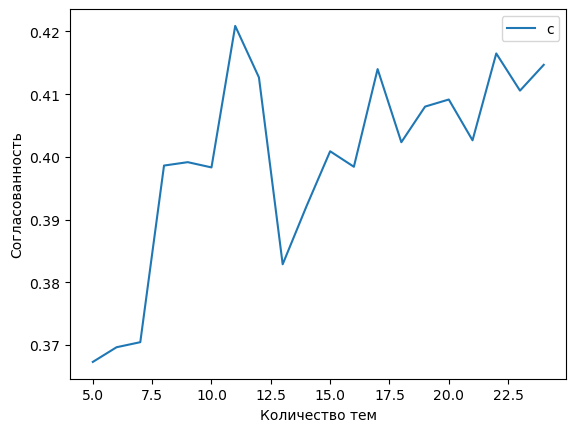

In [34]:
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_ru)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
#plt.suptitle("Качество модели LDA на русском подкорпусе")
plt.show()

In [35]:
lda_model_ru = models.LdaModel(corpus=corpus_tfidf_ru,
                               id2word=dictionary_ru,
                               num_topics=15)

In [36]:
lda_model_ru.print_topics(num_topics=10, num_words=10)

[(9,
  '0.011*"палестинский" + 0.007*"оккупировать" + 0.005*"израильский" + 0.005*"палестина" + 0.005*"иерусалим" + 0.004*"оккупационный" + 0.003*"мученик" + 0.003*"палестинец" + 0.003*"аль-кидва" + 0.002*"израиль"'),
 (1,
  '0.003*"2001/06/27" + 0.003*"2001/03/02" + 0.002*"шельф" + 0.002*"континентальный" + 0.001*"2001/09/10" + 0.001*"2001/09/18" + 0.001*"титульный" + 0.001*"морской" + 0.001*"декабрь" + 0.001*"2001/01/26"'),
 (4,
  '0.004*"оружие" + 0.003*"стрелковый" + 0.003*"вооружение" + 0.002*"марка" + 0.002*"юнмовик" + 0.002*"лёгкий" + 0.002*"ядерный" + 0.002*"разоружение" + 0.002*"quot" + 0.001*"ассамблея"'),
 (14,
  '0.002*"женщина" + 0.002*"княжество" + 0.001*"леса" + 0.001*"выброс" + 0.001*"2001/02/07" + 0.001*"2001/12/19" + 0.001*"2001/02/14" + 0.001*"2001/04/05" + 0.001*"2001/07/16" + 0.001*"ребёнок"'),
 (5,
  '0.006*"quot" + 0.004*"торговля" + 0.004*"развитие" + 0.004*"юнктад" + 0.003*"предпринимательство" + 0.003*"лесной" + 0.003*"рабочий" + 0.003*"страна" + 0.003*"совеща

In [37]:
my_dict_ru = {'Topic_' + str(i): [token for token, score in lda_model_ru.show_topic(i, topn=10)] for i in range(0, lda_model_ru.num_topics)}

In [38]:
my_dict_ru

{'Topic_0': ['2001/11/08',
  'the',
  'e-mail',
  'fax',
  'гибралтар',
  'гибралтарский',
  'and',
  'tel',
  'декабрь',
  'руанда'],
 'Topic_1': ['2001/06/27',
  '2001/03/02',
  'шельф',
  'континентальный',
  '2001/09/10',
  '2001/09/18',
  'титульный',
  'морской',
  'декабрь',
  '2001/01/26'],
 'Topic_2': ['мдп',
  'совет',
  'заседание',
  'безопасность',
  'утверждение',
  'повестка',
  'предварительный',
  'правило',
  'комитет',
  'полномочие'],
 'Topic_3': ['моонрзс',
  'космический',
  'сахара',
  'референдум',
  '2001/10/01',
  '2001/04/09',
  'эстонский',
  'полисарио',
  'западный',
  'пространство'],
 'Topic_4': ['оружие',
  'стрелковый',
  'вооружение',
  'марка',
  'юнмовик',
  'лёгкий',
  'ядерный',
  'разоружение',
  'quot',
  'ассамблея'],
 'Topic_5': ['quot',
  'торговля',
  'развитие',
  'юнктад',
  'предпринимательство',
  'лесной',
  'рабочий',
  'страна',
  'совещание',
  'стандарт'],
 'Topic_6': ['безопасность',
  'совет',
  'письмо',
  'ирак',
  'республика',

## Визуализация

In [63]:
import pyLDAvis
import pyLDAvis.gensim_models

In [64]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_ru, corpus_tfidf_ru, dictionary_ru)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.165432  0.012227       1        1  31.781115
6      0.142190 -0.121467       2        1  31.540585
10     0.207896  0.107013       3        1  22.489812
2      0.072276 -0.047602       4        1   6.440316
4     -0.016090  0.000487       5        1   0.801986
11    -0.015496 -0.008041       6        1   0.784822
9     -0.051622 -0.003910       7        1   0.781347
7     -0.063884  0.014967       8        1   0.751249
12    -0.052057  0.000254       9        1   0.711241
8     -0.044781  0.011691      10        1   0.702119
3     -0.070037  0.005244      11        1   0.659916
0     -0.079045  0.008690      12        1   0.651498
1     -0.074384  0.008438      13        1   0.646429
13    -0.062508  0.001581      14        1   0.630513
14    -0.057889  0.010427      15        1   0.627051, topic_info=                Term        Freq       Total Category  logprob  loglift
7155            quot  575.000000  575.000000  Default  30.0000  30.0000
19364            мдп  107.000000  107.000000  Default  29.0000  29.0000
4504    палестинский   98.000000   98.000000  Default  28.0000  28.0000
1396    транспортный  220.000000  220.000000  Default  27.0000  27.0000
5339     израильский   73.000000   73.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
6597         ядерный    0.239418   23.358956  Topic15  -7.8278   0.4914
1074          страна    0.253335  157.698126  Topic15  -7.7713  -1.3618
1407         человек    0.250450  130.888890  Topic15  -7.7827  -1.1869
579          комитет    0.245701  133.661604  Topic15  -7.8019  -1.2271
857    правительство    0.240125   97.690357  Topic15  -7.8248  -0.9365

[911 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5932       1  0.125818      1-й
5932       3  0.125818      1-й
5932       4  0.629091      1-й
5933       4  0.768900    10-14
17386      3  0.536955      11a
...      ...       ...      ...
6597       2  0.642152  ядерный
6597       3  0.042810  ядерный
6597       4  0.042810  ядерный
6597       5  0.085620  ядерный
6597       6  0.042810  ядерный

[1354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 11, 3, 5, 12, 10, 8, 13, 9, 4, 1, 2, 14, 15])



---



---



## NMF

In [55]:
from sklearn.decomposition import NMF

In [56]:
nmf = NMF(n_components=10, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, l1_ratio=0.5)
nmf_model = nmf.fit(docs_vectorized)

In [57]:
nmf_all_topics = []
print_topics(nmf_model, vectorizer, nmf_all_topics)

Topic 0:
[('организация', 43.78055289066034), ('страна', 39.35804668002534), ('развитие', 35.565987135134186), ('объединить', 26.276471828760805), ('нация', 25.985508514657255)]
Topic 1:
[('безопасность', 49.00767989571757), ('совет', 47.02647602050189), ('мир', 22.464928982870834), ('организация', 22.12775958441601), ('международный', 21.829277745770256)]
Topic 2:
[('quot', 77.01868577095497), ('государство', 36.375195526842006), ('статья', 35.297633404730874), ('участник', 29.430030840752313), ('суд', 28.232119253026216)]
Topic 3:
[('страна', 26.460883090252644), ('quot', 18.340607520359335), ('группа', 14.818126861156156), ('развитие', 13.464928284656764), ('данные', 13.127466751334138)]
Topic 4:
[('право', 116.18012710212987), ('человек', 72.9261310134632), ('международный', 28.917388943156656), ('специальный', 20.396375778575813), ('народ', 20.119992123983536)]
Topic 5:
[('комитет', 67.47543751545601), ('генеральный', 56.215420893285525), ('организация', 51.728836434867596), ('рез

In [58]:
for i,topic in enumerate(nmf_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

-------------------------------
Тема  0
организация
страна
развитие
объединить
нация
-------------------------------
Тема  1
безопасность
совет
мир
организация
международный
-------------------------------
Тема  2
quot
государство
статья
участник
суд
-------------------------------
Тема  3
страна
quot
группа
развитие
данные
-------------------------------
Тема  4
право
человек
международный
специальный
народ
-------------------------------
Тема  5
комитет
генеральный
организация
резолюция
сессия
-------------------------------
Тема  6
женщина
ребёнок
право
закон
образование
-------------------------------
Тема  7
сша
организация
расход
объединить
период
-------------------------------
Тема  8
quot
должный
транспортный
пункт
средство
-------------------------------
Тема  9
статья
конвенция
сторона
quot
государство


-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import zipfile
from zipfile import ZipFile

with zipfile.ZipFile('C:\\tmdasha\\MUNnew.zip', 'r') as z:
  z.extractall('MUN')

print('Done')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


with open('C:\\tmdasha\\stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

stop_words.extend(stopwords.words('russian'))

stw = list(stop_words)


In [ ]:
import os
corpus_files = os.listdir('MUN/MUN')

import pymorphy2 as pm
morph = pm.MorphAnalyzer()

nltk.download('punkt')

docs_new = []

for ind, txt in enumerate(corpus_files):
    with open('MUN/MUN//' + txt, 'r', encoding='utf-8') as f:
        text = nltk.word_tokenize(f.read().lower())
        text = [token for token in text if len(token) > 2]
        text = [morph.parse(token)[0].normal_form for token in text if token not in stop_words]
        docs_new.append(' '.join(text))

-----------------------------------------------------------------------------------------------------------------------------------------------------------

## Bert

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="russian", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs_new)
                                          

In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

In [ ]:
topic_model.get_topic(0)  

In [ ]:
topic_model.topics_[:10]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)